In [1]:
from MMT_reduce_module import *

In [2]:
from __future__ import print_function
import numpy as np
import scipy as sp
import scipy.ndimage
from astropy.io import fits
import sys
import numpy.ma as ma
import math
import pidly
import os
import glob
import time
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.visualization import ZScaleInterval
interval = ZScaleInterval()

## MMT_reduce_module Testing

#### The purpose of this notebook is to test functions in the MMT module one-by-one and examine the outputs at each step.

Major to-do items (April 4, 2019): 

* Fix saturated data!
    * Examine how sky frames are being made 
    * Examine how sky subtraction is being performed on science data
    * Determine best practice of aligning saturated frames
    * plt.imshow reduced steps
    * Stacking size issue 
    
* Determine how flatfield generation is being done and improve if need be
    * Debug negative dark frames/negative flat frame issues? -- **done, 5/23**
    * Double-check dome flat correction, now that twilight flat correction is working (with correct inputs)
    
More to-do items (last updated 5/23):
* Ensure corquad correction is applied prior to analysis steps - **done, 5/23**
* Rotation angle correction and image flip for MMT data (appears to be same VLT conventions) - update within module
* Cross-check sky subtraction in case of very saturated data, and if small changes in rotation angle make difference


In [3]:
cd /Volumes/Passport4TB/MinMs_Data_Testing/HIP12097_MMT_20161012/30.0/

/Volumes/Passport4TB/MinMs_Data_Testing/HIP12097_MMT_20161012/30.0


### Set up paths to raw data and definitions

In [5]:
path_to_raw_sci = '/Volumes/Passport4TB/MinMs_Data_Testing/HIP12097_MMT_20161012/30.0/'
path_to_raw_darks = '/Volumes/Passport4TB/MinMs_Data_Testing/20161012_Calibrations/darks/'
path_to_raw_flats = '/Volumes/Passport4TB/MinMs_Data_Testing/20161012_Calibrations/twilight/'
objname = 'HIP12097_30.0s'
flattype = 0 # 0 for sky, 1 for lamp
saturated = 0 # 0 if unsaturated, 1 if saturated
alignflag = 0 # 0 if single star or faint companion, 1 if equal brightness binary or difficult to align for some reason
imsize = 1024

## The following cells are each of the steps of the reduce_raw_sci function

In [6]:
# Make list of science frames and check exposure time 
scilist = glob.glob(path_to_raw_sci + 'q*.fits')

print(f"Number of science frames found: {len(scilist)} \n")


Number of science frames found: 23 



In [7]:
scitimes = [fits.getheader(im, ignore_missing_end = True)['EXPTIME'] for im in scilist]

# check if all of the exposure times in the current directory are the same:
if all(x == scitimes[0] for x in scitimes):
    print("Science frame exposure time: " + str(scitimes[0]) + "\n")
else:
    raise Exception("Exposure times for given list of files do not match. \
    You may need to make/define separate subfolders for different exptimes.")

sci_exptime = scitimes[0]

n = len(scilist)


# get header from science frames to work with
sciheader = fits.getheader(scilist[0])


Science frame exposure time: 30.0



In [8]:
# check for datacubes
if len(fits.getdata(scilist[0]).shape) == 3: # check for data cubes of science frames
    sciarray = np.zeros([imsize,imsize,n*fits.getdata(scilist[0]).shape[0]])
else:
    sciarray = np.zeros([imsize,imsize,n])

if len(fits.getdata(scilist[0]).shape) == 3: # check for data cubes of science frames    
    totalframes = n*fits.getdata(scilist[0]).shape[0]
else:
    totalframes = n

In [9]:
# in case data were rotated during observing sequence, set up empty array of rotation angles
angle = np.zeros(totalframes)

im_index = 0

for ii in range(0, n):
    
    im = fits.getdata(scilist[ii], ignore_missing_end=True)
    header = fits.getheader(scilist[ii],ignore_missing_end=True)
    
    if len(im.shape) == 3: # check for data cubes of science frames
        assert not np.any(np.isnan(im))
        for jj in range(0, im.shape[0]):
            sciarray[:,:,im_index] = im[jj,:,:]
            angle[im_index] = (header['PA'] - header['ROT']) * (np.pi/180.0)
            im_index += 1
    else: 
        sciarray[:,:,ii] = im  
        angle[ii] = (header['PA'] - header['ROT']) * (np.pi/180.0)
    header = fits.getheader(scilist[ii], ignore_missing_end=True)





In [10]:
print(angle)
print(im)

[-0.8097801  -0.79223818 -0.78691628 -0.78168544 -0.77638127 -0.74934932
 -0.74371575 -0.72172952 -0.71567543 -0.70941748 -0.7029843  -0.69229816
 -0.6857176  -0.67902415 -0.67209551 -0.66104097 -0.65400968 -0.64674223
 -0.63949708 -0.61916263 -0.61143682 -0.60370276 -0.59585376]
[[   0.      1307.7513  1220.6771  ... 1333.3844  1330.8589  1314.3203 ]
 [ 325.75934 1451.2681  1421.4031  ... 1336.4957  1326.654   1393.9655 ]
 [ 333.6266  1265.9246  1315.5254  ... 1387.3607  1431.5577  1406.3093 ]
 ...
 [ 317.50174 1442.0865  1524.1453  ... 1567.9668  1677.1624  2105.857  ]
 [ 321.8183  1398.6318  1446.0332  ... 1579.5536  1814.9286  2545.2412 ]
 [ 329.59885 1403.5455  1579.2537  ... 1719.2898  2113.485   2637.5386 ]]


Creating and applying master darks and flats...

Found 16 darks with exposure times of 30.0. 



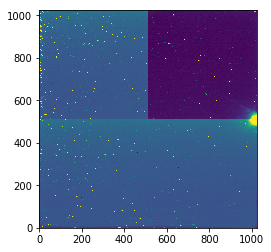

In [11]:
#MASTER_DARK

print("Creating and applying master darks and flats...\n")    

# create master dark matching science exposure times
med_dark = dark_combine(path_to_raw_darks, sci_exptime, imsize, objname) 

vmin, vmax = interval.get_limits(med_dark)
plt.imshow(med_dark, vmin=vmin, vmax=vmax, origin='lower')

In [12]:

# subtract off the median dark frame from each of the science frames
for ii in range (0, totalframes):
    sciarray[:,:,ii] -= med_dark


In [13]:
flatlist = glob.glob(path_to_raw_flats + '**/q*fits',recursive = True)
flatlist

['/Volumes/Passport4TB/MinMs_Data_Testing/20161012_Calibrations/twilight/sky flat/20.0/qim_2160.fits',
 '/Volumes/Passport4TB/MinMs_Data_Testing/20161012_Calibrations/twilight/sky flat/20.0/qim_2161.fits',
 '/Volumes/Passport4TB/MinMs_Data_Testing/20161012_Calibrations/twilight/sky flat/20.0/qim_2162.fits',
 '/Volumes/Passport4TB/MinMs_Data_Testing/20161012_Calibrations/twilight/sky flat/20.0/qim_2163.fits',
 '/Volumes/Passport4TB/MinMs_Data_Testing/20161012_Calibrations/twilight/sky flat/20.0/qim_2164.fits',
 '/Volumes/Passport4TB/MinMs_Data_Testing/20161012_Calibrations/twilight/sky flat/20.0/qim_2166.fits',
 '/Volumes/Passport4TB/MinMs_Data_Testing/20161012_Calibrations/twilight/sky flat/20.0/qim_2167.fits',
 '/Volumes/Passport4TB/MinMs_Data_Testing/20161012_Calibrations/twilight/sky flat/20.0/qim_2168.fits',
 '/Volumes/Passport4TB/MinMs_Data_Testing/20161012_Calibrations/twilight/sky flat/20.0/qim_2169.fits',
 '/Volumes/Passport4TB/MinMs_Data_Testing/20161012_Calibrations/twilight/

In [15]:
for im in flatlist:
    print(fits.getheader(im)['FILTER'])

Ks band
Ks band
Ks band
Ks band
Ks band
Ks band
Ks band
Ks band
Ks band
Ks band
Ks band
Ks band
Ks band
Ks band
Ks band
Ks band
Ks band
Ks band
Ks band
Ks band
Ks band
Ks band
Ks band
Ks band
Ks band
Ks band
Ks band
Ks band
Ks band
Ks band
Ks band
Ks band
Ks band
Ks band
Ks band
Ks band
Ks band
Ks band
Ks band
Ks band
Ks band
Ks band
Ks band
Ks band
Ks band
Ks band
Ks band
Ks band
Ks band
Ks band
Ks band
Ks band
Ks band
Ks band
Ks band


Found 55 twilight flats with exposure times of 20.0. 



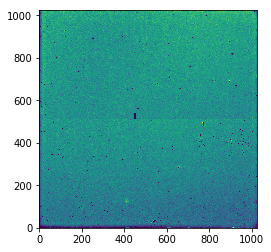

In [16]:
#MEDIAN_AND_MASTER_FLAT

# create the masterflat 
med_flat, master_flat, flatheader = process_flats(path_to_raw_flats, path_to_raw_darks, imsize, flattype, objname)

vmin, vmax = interval.get_limits(med_flat)
plt.imshow(med_flat, vmin=vmin, vmax=vmax, origin='lower')

In [17]:
# divide each science frame by the masterflat frame
for ii in range(0, totalframes):
    sciarray[:,:,ii] /= master_flat



Creating bad pixel map and correcting for bad pixels and cosmic rays. 
 This may take a moment... 



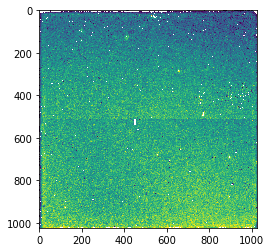

In [18]:
#BAD_PIXEL_MAP

print("Creating bad pixel map and correcting for bad pixels and cosmic rays. \n",
     "This may take a moment... \n") 

# create bad pixel map
badflat = badpixelmap(med_flat, objname, flatheader)  

vmin, vmax = interval.get_limits(badflat)
plt.imshow(badflat, vmin=vmin, vmax=vmax)

In [19]:

# correct the bad pixels and cosmic rays
reduced_sciarray = correct_bad_pixels(sciarray, badflat)

# print(reduced_sciarray)

Correcting image #0
Correcting image #1
Correcting image #2
Correcting image #3
Correcting image #4
Correcting image #5
Correcting image #6
Correcting image #7
Correcting image #8
Correcting image #9
Correcting image #10
Correcting image #11
Correcting image #12
Correcting image #13
Correcting image #14
Correcting image #15
Correcting image #16
Correcting image #17
Correcting image #18
Correcting image #19
Correcting image #20
Correcting image #21
Correcting image #22


In [21]:
# write out a test reduced science image 
fits.writeto('test_reduced_science.fits', reduced_sciarray[:,:,0], overwrite=True)

In [22]:
#MASTER_SKY
print("Creating master sky from science frames...\n") 

# create median sky from stack of science images
sky_output = create_sky_frames(reduced_sciarray, sciheader, objname, angle)



Creating master sky from science frames...



1599.0038585588645


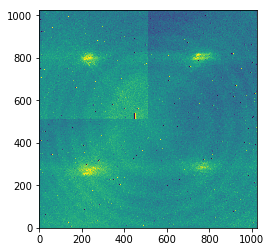

In [23]:
# get median and examine sky output:
print(np.median(sky_output[1]))
vmin, vmax = interval.get_limits(sky_output[1])
plt.imshow(sky_output[1], vmin=vmin, vmax=vmax, origin='lower')

In [24]:
print(reduced_sciarray,sky_output, angle)

[[[1621.85413618 1616.4680098  1594.50573204 ... 1602.42216938
   1699.6179386  1837.50854725]
  [1621.85413618 1616.4680098  1594.50573204 ... 1612.13636087
   1699.6179386  1825.73853923]
  [1632.80524977 1619.71124104 1603.17729022 ... 1610.14362169
   1682.14292892 1807.13892112]
  ...
  [1607.93500118 1590.20889533 1586.58568559 ... 1597.85266829
   1709.84759305 1832.760502  ]
  [1607.39920419 1585.99818714 1584.7310093  ... 1604.5928407
   1705.3316524  1830.90146233]
  [1603.15331934 1585.99818714 1586.69441424 ... 1595.49690482
   1704.59372444 1832.760502  ]]

 [[1642.33809647 1616.4680098  1597.16275465 ... 1608.03591139
   1699.6179386  1837.50854725]
  [1638.67392565 1614.49195247 1597.16275465 ... 1612.13636087
   1699.6179386  1825.73853923]
  [1638.67392565 1619.71124104 1605.84318597 ... 1608.85831245
   1671.2308052  1816.20496003]
  ...
  [1607.93500118 1590.20889533 1586.69441424 ... 1595.49690482
   1704.59372444 1844.19753804]
  [1607.93500118 1590.20889533 1586.6

In [25]:
# apply sky subtraction to each science image 
skysub_science_array, rot_flag = sky_subtract(reduced_sciarray, sky_output, angle)

In [26]:
#INDIVIDUAL_REDUCED_SCI_IMAGES
t0=time.time()

# initialize blank list to hold all of the reduced science image names
scinames_list = []


for ii in range(0, totalframes):
    print(f"Saving reduced frame #{ii}")
    sciname = 'reducedsci_00' + str(ii) + '.fits'
    if ii >= 10:
        sciname = 'reducedsci_0' + str(ii) + '.fits'
    if ii >= 100:
        sciname = 'reducedsci_' + str(ii) + '.fits'
    fits.writeto(sciname, skysub_science_array[:,:,ii], sciheader, overwrite = True, output_verify='silentfix')
    scinames_list.append(sciname)
    
t1=time.time()
print("Time taken: ", (t1-t0)/60.)

Saving reduced frame #0
Saving reduced frame #1
Saving reduced frame #2
Saving reduced frame #3
Saving reduced frame #4
Saving reduced frame #5
Saving reduced frame #6
Saving reduced frame #7
Saving reduced frame #8
Saving reduced frame #9
Saving reduced frame #10
Saving reduced frame #11
Saving reduced frame #12
Saving reduced frame #13
Saving reduced frame #14
Saving reduced frame #15
Saving reduced frame #16
Saving reduced frame #17
Saving reduced frame #18
Saving reduced frame #19
Saving reduced frame #20
Saving reduced frame #21
Saving reduced frame #22
Time taken:  0.036831998825073244


In [27]:
idl = pidly.IDL('/Applications/exelis/idl85/bin/idl')

In [28]:
idl('ds9')

% Compiled module: DS9.
Spawning ds9 with title: ds9_1561387929
waiting...
waiting...
waiting...
waiting...
waiting...
waiting...
waiting...
waiting...
waiting...
waiting...
waiting...
waiting...
it worked!


In [29]:
!echo $IDL_PATH

:+/Users/kwardduong/Software/IDL_extras:+/Applications/exelis/idl85/lib/


In [54]:
# get current directory where reduced frames are written
current_dir = os.getcwd()

# measure star positions in all of the images
xcen, ycen = measure_star_centers(skysub_science_array, scinames_list, sciheader, saturated, 0, current_dir, saveframes = True)


% Compiled module: MRDFITS.
% Compiled module: FXPOSIT.
% Compiled module: MRD_HREAD.
% Compiled module: FXPAR.
% Compiled module: GETTOK.
% Compiled module: VALID_NUM.
% Compiled module: MRD_SKIP.
% Compiled module: ARRAY_INDICES.
% Compiled module: MPFIT2DPEAK.
% Compiled module: MPFIT.
% Compiled module: MPFIT2DFUN.
Overwriting existing science frames with star position values: reducedsci_000.fits
Overwriting existing science frames with star position values: reducedsci_001.fits
Overwriting existing science frames with star position values: reducedsci_002.fits
Overwriting existing science frames with star position values: reducedsci_003.fits
Overwriting existing science frames with star position values: reducedsci_004.fits
Overwriting existing science frames with star position values: reducedsci_005.fits
Overwriting existing science frames with star position values: reducedsci_006.fits
Overwriting existing science frames with star position values: reducedsci_007.fits
Overwriting exi

In [55]:
print('xcen:', xcen, 'ycen:', ycen)

xcen: [226.8091335  229.79714805 232.5568159  214.4375884  224.84946292
 413.06097977 894.13413588 271.01691673 251.41237606 238.67857752
 258.77703941 721.11061208 717.51329128 706.49413827 711.99216621
 704.9280649  693.92759522 692.9416485  694.44853817 486.31293888
 461.56325312 453.23204282 478.92841418] ycen: [303.88357598 311.05314357 322.80871268 303.34166689 288.49554086
 118.93896047 633.84401628 799.98789863 811.75351732 802.39058778
 780.66637783 764.74156302 769.08190554 766.59549751 750.06268971
 276.64678096 306.97291952 272.55066205 264.95629354 531.2927283
 550.80061354 527.59828492 511.64190419]


In [56]:
#SHIFTED_IMAGES
#STACKED
#FINAL
t0=time.time()
# final step (!) - shift and combine all of the images.
rotate_shift_align(xcen, ycen, angle, skysub_science_array, objname, sciheader, current_dir, imsize=1024)

t1 = time.time()
timetaken = (t1-t0)/60.
print(f"Completed reduction of {totalframes} images in {timetaken} minutes.")

2173 2144
Shifting image 0 of 23...
Shifting image 1 of 23...
Shifting image 2 of 23...
Shifting image 3 of 23...
Shifting image 4 of 23...
Shifting image 5 of 23...
Shifting image 6 of 23...
Shifting image 7 of 23...
Shifting image 8 of 23...
Shifting image 9 of 23...
Shifting image 10 of 23...
Shifting image 11 of 23...
Shifting image 12 of 23...
Shifting image 13 of 23...
Shifting image 14 of 23...
Shifting image 15 of 23...
Shifting image 16 of 23...
Shifting image 17 of 23...
Shifting image 18 of 23...
Shifting image 19 of 23...
Shifting image 20 of 23...
Shifting image 21 of 23...
Shifting image 22 of 23...
% Compiled module: MRDFITS.
% Compiled module: FXPOSIT.
% Compiled module: MRD_HREAD.
% Compiled module: FXPAR.
% Compiled module: GETTOK.
% Compiled module: VALID_NUM.
% Compiled module: MRD_SKIP.
% Compiled module: MWRFITS.
% Compiled module: FXADDPAR.
% Compiled module: SXDELPAR.
Completed reduction of 23 images in 0.6714175979296366 minutes.


In [31]:
!open .








## everything below is random testing

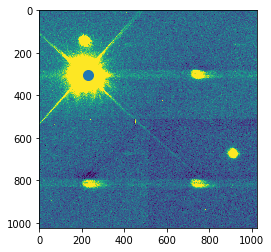

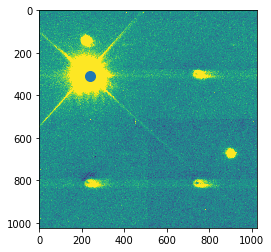

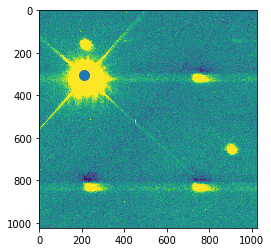

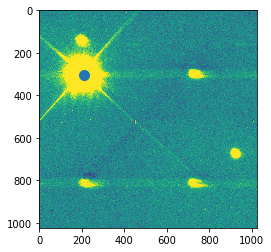

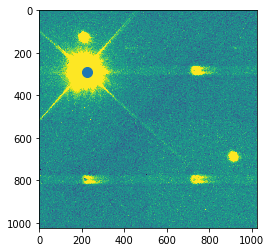

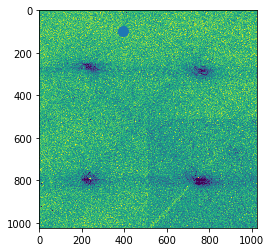

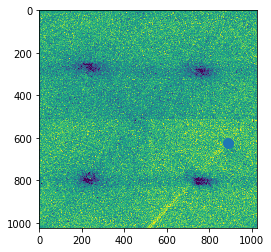

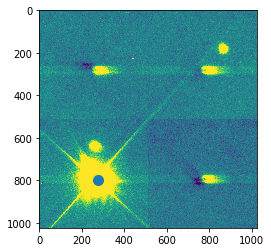

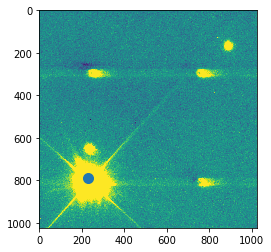

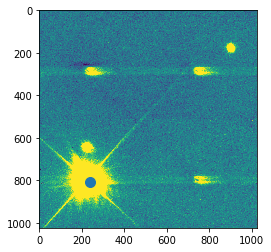

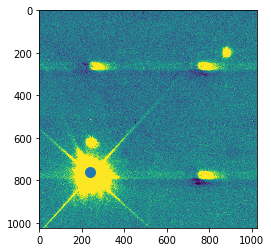

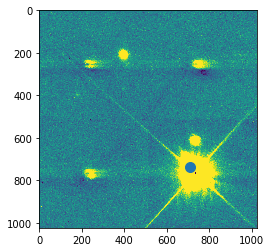

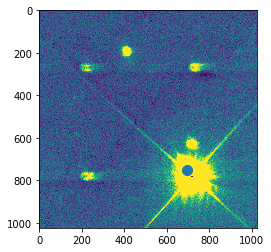

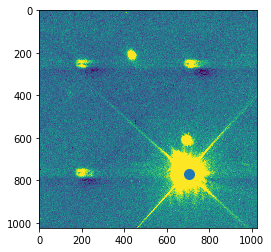

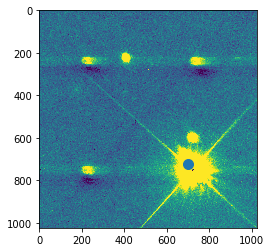

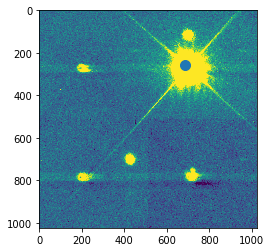

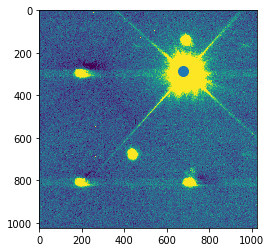

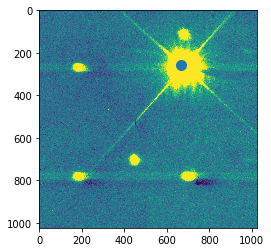

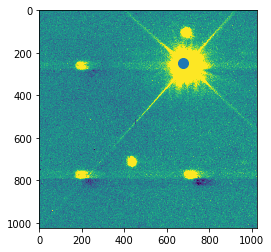

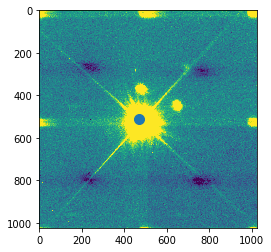

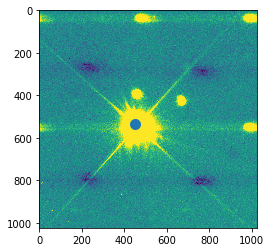

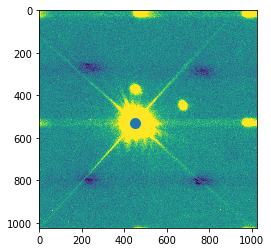

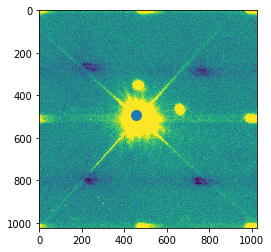

In [30]:
reduced_array = glob.glob('reduced*')

for ii in reduced_array:
    reducedsci = fits.getdata(ii)
    reducedsci_header = fits.getheader(ii)
    
    xcen = reducedsci_header['CRPIX1A']
    ycen = reducedsci_header['CRPIX2A']
    
    vmin1, vmax1 = interval.get_limits(reducedsci)
    plt.imshow(reducedsci, vmin=vmin1, vmax=vmax1)
    plt.plot(xcen, ycen, marker = 'o', markersize = 10)
    plt.show()



In [ ]:
n = len(scinames_list)

xcen = np.zeros(n)
ycen = np.zeros(n)

idl = pidly.IDL('/Applications/exelis/idl/bin/idl')
idl_changedir = 'cd, ' + f'"{current_dir}"'
idl(idl_changedir)

for ii in range(0, 1):
    # idl('name = "'+sciname+'"')
    idl('name = "'+ scinames_list[ii] +'"')
    idl('im=MRDFITS(name,0,/FSCALE,/SILENT)')
    idl('tmp=SMOOTH(im,21,/EDGE_TRUNCATE)')
    idl('tmp[0:100,*]=0.0')
    idl('tmp[924:1023,*]=0.0')
    idl('tmp[*,0:100]=0.0')
    idl('tmp[*,1000:1023]=0.0')
    idl('foo=MAX(tmp,ind,/NAN)')
    idl('ind=ARRAY_INDICES(tmp,ind)')
    idl('print, foo')
    
    if saturated == 0:
        idl('GCNTRD,im[ind[0]-20:ind[0]+20,ind[1]-20:ind[1]+20],20,20,xcen,ycen,3.0')
        idl('xcen += ind[0]-20.0')
        idl('ycen += ind[1]-20.0')
        xcen[ii], ycen[ii] = idl.xcen, idl.ycen
    else:
        idl('x=ind[0]')
        idl('y=ind[1]')
        idl('sim = im[x-20:x+20,y-20:y+20]')
        idl('weights = (sim*0.0)+1.0')
        idl('weights[WHERE(sim ge 0.7*MAX(sim,/NAN))]=0.0')
        idl('fit=MPFIT2DPEAK(sim,A,WEIGHTS=weights)')
        idl('xcen = A[4]+(x-20.0)')
        idl('ycen = A[5]+(y-20.0)')
        xcen[ii], ycen[ii] = idl.xcen, idl.ycen
        idl('print, A[5]')

print(xcen[ii],ycen[ii])

In [ ]:
idl.A

In [ ]:
#Running all the above reduction steps in one go
reduce_raw_sci(path_to_raw_sci, path_to_raw_darks, path_to_raw_flats, objname, flattype, saturated, alignflag, imsize = 1024)